# Applying WOfS and its Accuracy Assessment to Africa <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2)

## Background
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) is a derived product from Landsat 8 satellite observations as part of provisional Landsat Collection 2 surface reflectance and shows water detected for selected areas of Africa.

Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. 
Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

## Description
This notebook explains both the structure of the WOFLs, and how you can use WOfS derived product to perform accuracy assessment of the product using ground truth dataset.

The data in a WOFL is stored as a bit field. 
This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc).
In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 

The notebook demonstrates how to:

1. Load WOFL data for a given location and time period 
2. Inspect the WOFL bit flag information
3. Use the WOFL bit flags to create a binary mask
4. Apply WOFL-based masks to fractional cover dataset 
5. Generating a confusion error matrix for WOFL classification
6. Assessing the accuracy of the classification 
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

### Load packages

In [25]:
%matplotlib inline

import datacube
from datacube.utils import masking 
import sys
import os
import dask 
import rasterio as rio 
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import matplotlib.pyplot as plt
import earthpy.plot as ep 
from rasterio.mask import mask
from rasterio.plot import show 

sys.path.append("../Scripts")
from deafrica_plotting import display_map
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard
from deafrica_spatialtools import xr_rasterize

## Stratify Sampling Points

Code to create a simple water mask to use to stratify sample points.
- Calculates Normalized Difference Water Index on each Landsat image in the time series
- Creates a composite of the NDWI times series using the max, median, percentile NDWI value across the timeseries

### Analysis parameters

## STEPS TO TRANSFER 

- Function to mask Landsat clouds using QA bands

- Function to rename Landsat 5 and 8 bands 

- Add indices NDWI(green, SWIR1) and NDWI2 (NIR, SWIR2)

- Create time band using the code in the following cell - Reason?

In [13]:
- //L8 = L8.map(add_doy);
 var createTimeBand = function(image) {
  return image.addBands(image.metadata('system:time_start').divide(1e18));
};

SyntaxError: invalid syntax (<ipython-input-13-e65e088e413b>, line 1)

- Landsat 5 and 7 surface reflectance

- Map NDWI over collection

- Get maximum and median and 95 percentile value of each band for the timeseris collection 

- Select band and clip to geometry

- Set NDWI threshold for water mask 

- Show the water mask and export it as a layer 

## Validation Data Sampling 

In [26]:
JRC = '../Supplementary_data/Validation/GSWE_CentralAEZ-0000065536-0000065536.tif'
Boundary = '../Supplementary_data/Validation/Africa_Boundary_250k.shp'

In [27]:
with rio.open(JRC) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 49869, 'height': 64396, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852358564, 0.0, 21.960574761699448,
       0.0, -0.0002694945852358564, -2.11849693453906), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [28]:
Africa_Boundary = gpd.read_file(Boundary)
GSWE = xr.open_rasterio(JRC)

In [ ]:
mask = xr_rasterize(Africa_Boundary.iloc[[0]], GSWE)
output = GSWE.where(mask)

Rasterizing to match xarray.DataArray dimensions (64396, 49869) and projection system/CRS (e.g. +init=epsg:4326)


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [20]:
GSWE = xarray.open_rasterio(JRC, chunks={'x':1000, 'y':1000})

In [21]:
Africa_Boundary = gpd.read_file(Boundary)

In [6]:
#checking the coordinate reference system 
print('Africa Boundary crs: ', Africa_Boundary.crs)
print('GSWE crs: ', GSWE.crs)

Africa Boundary crs:  epsg:4326
GSWE crs:  +init=epsg:4326


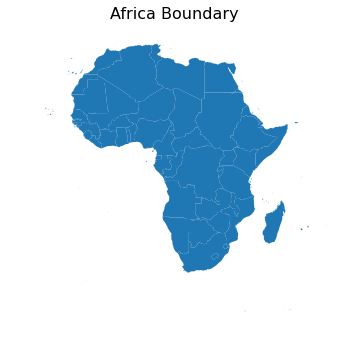

In [7]:
# plot the data
fig, ax = plt.subplots(figsize = (6, 6))
Africa_Boundary.plot(ax=ax)
ax.set_title("Africa Boundary", 
             fontsize = 16)
ax.set_axis_off();

Rasterizing to match xarray.DataArray dimensions (64396, 49869) and projection system/CRS (e.g. +init=epsg:4326)


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


,Array,Chunk
Bytes,25.69 GB,8.00 MB
Shape,"(1, 64396, 49869)","(1, 1000, 1000)"
Count,19502 Tasks,3250 Chunks
Type,float64,numpy.ndarray


In [9]:
from shapely.geometry import mapping 
geoms = [mapping(geoms[0])]

## Accuracy Assessment for WOFLs

Accuracy assessment includes generating a confusion error matrix for a WOFL binary classification.

The inputs for the assessment are a binary classification of water/non-water output and a shapefile conaining water/non-water points to serve as the "ground-truth" dataset. A confusion error matrix containing overall, producer's and user's accuracy is the output of this analysis. 

### Analysis Parameters

In [ ]:
pred_tif = ''
grd_truth = ''
aez = ''

#### Load the dataset 

In [ ]:
#ground truth shapefile
ground_truth = gpd.read_file(grd_truth).to_crs('EPSG:6933')

In [ ]:
# rename the class column to 'actual'
ground_truth = ground_truth.rename(columns={'class':'Actual'})
ground_truth.head()

Clip ground_truth data points to the simplified AEZ

In [ ]:
#open shapefile
aez=gpd.read_file(aez_region).to_crs('EPSG:6933')
# clip points to region
ground_truth = gpd.overlay(ground_truth,aez,how='intersection')

Raster of predicted classes

In [ ]:
# Raster of predicted classes
prediction = rasterio.open(pred_tif)

#### Extract a list of coordinate values 

In [ ]:
coords = [(x,y) for x, y in zip(ground_truth.geometry.x, ground_truth.geometry.y)]

#### Sample the prediction raster at the ground truth coordinate

In [ ]:
# Sample the raster at every point location and store values in DataFrame
ground_truth['Prediction'] = [int(x[0]) for x in prediction.sample(coords)]
ground_truth.head()

### Create a Confusion Matrix 

In [ ]:
confusion_matrix = pd.crosstab(ground_truth['Actual'],
                               ground_truth['Prediction'],
                               rownames=['Actual'],
                               colnames=['Prediction'],
                               margins=True)
confusion_matrix

#### Calculate User's and Producer's Accuracy

##### User's accuracy

In [ ]:
confusion_matrix["User's"] = [confusion_matrix.loc[0, 0] / confusion_matrix.loc[0, 'All'] * 100,
                              confusion_matrix.loc[1, 1] / confusion_matrix.loc[1, 'All'] * 100,
                              np.nan]

##### Producer's accuracy 

In [ ]:
producers_accuracy = pd.Series([confusion_matrix[0][0] / confusion_matrix[0]['All'] * 100,
                                confusion_matrix[1][1] / confusion_matrix[1]['All'] * 100]
                         ).rename("Producer's")

confusion_matrix = confusion_matrix.append(producers_accuracy)

##### Overall accuracy

In [ ]:
confusion_matrix.loc["Producer's", "User's"] = (confusion_matrix.loc[0, 0] + 
                                                confusion_matrix.loc[1, 1]) / confusion_matrix.loc['All', 'All'] * 100

F1 Score

The F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall), and is calculated as:

$$
\begin{aligned}
\text{Fscore} = 2 \times \frac{\text{UA} \times \text{PA}}{\text{UA} + \text{PA}}.
\end{aligned}
$$

Where UA = Users Accuracy, and PA = Producer's Accuracy

In [ ]:
fscore = pd.Series([(2*(confusion_matrix.loc[0, "User's"]*confusion_matrix.loc["Producer's", 0]) / (confusion_matrix.loc[0, "User's"]+confusion_matrix.loc["Producer's", 0])) / 100,
                    f1_score(ground_truth['Actual'], ground_truth['Prediction'], average='binary')]
                         ).rename("F-score")

confusion_matrix = confusion_matrix.append(fscore)

#### Tidy Confusion Matrix

- Limit decimal places,
- Add readable class names
- Remove non-sensical values

In [ ]:
# round numbers
confusion_matrix = confusion_matrix.round(decimals=2)

In [ ]:
# rename booleans to class names
confusion_matrix = confusion_matrix.rename(columns={0:'Non-crop', 1:'Crop', 'All':'Total'},
                                            index={0:'Non-crop', 1:'Crop', 'All':'Total'})

In [ ]:
#remove the nonsensical values in the table
confusion_matrix.loc['Total', "User's"] = '--'
confusion_matrix.loc["Producer's", 'Total'] = '--'
confusion_matrix.loc["F-score", 'Total'] = '--'
confusion_matrix.loc["F-score", "User's"] = '--'

In [ ]:
confusion_matrix

#### Export csv

In [ ]:
#confusion_matrix.to_csv('results/confusion_matrix.csv')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.7+253.ga031f3f4.dirty


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)